## Optimisation Research Focussing on Learning Rate, Batch-Size and Stride

### Key: Cathode = 0, Gate = 1, Tritium = 2
### Kernel Size: 2 µs (Exhibited Maximum Accuracy of 0.892 across Kernel Parameter Space - Corresponds to Filter Size of 200)

# Imports

Install tensorflow in your conda environment. Note that you need to have numpy-1.23.1. When I did this, I had to manually uninstall numpy-1.24.3 then install numpy-1.23.1, before installing tensorflow. The tensorflow install failed to install numpy-1.23.1, itself, even though it told me it was successful.

In [83]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import random

In [84]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sn

In [85]:
import pandas as pd
import awkward as ak
import pyarrow.parquet as pq

import hist
from hist import Hist, axis

import matplotlib as mpl
import matplotlib.patches as patches

In [86]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import ast

# Load data from Parquet file and convert to strings
data_path = 'LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [87]:
def normalise_array(arr):
    min_val = ak.min(arr, axis=-1)
    max_val = ak.max(arr, axis=-1)
    return (arr - min_val) / (max_val - min_val)

# Apply normalization to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

# Print or inspect the results
print(normalised_times)
print(normalised_samples)



[[0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.997, 0.998, 0.999, 1], ...]
[[0.00238, 0.00212, 0.00198, 0.00223, ..., 0.00251, 0.00211, 0.00133, 0], ...]


# Padding the Data

In [88]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))



print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))


times_lengths = ak.num(normalised_times, axis=1)
max_time_length = ak.max(times_lengths)
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))

print(f"Length After Padding: {len(padded_times[0])}")
    

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


Now lets pad the Sample data

In [89]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(normalised_samples[0])}")
print("Structure of 'times':", ak.type(arr['samples']))


samples_lengths = ak.num(normalised_samples, axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), 'constant') for sub_array in ak.to_list(array)]
        )
    )

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


# Creating the Training and Test Data (AwkwardArrays)

In [90]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Separate times and samples as individual arrays

X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

X_combined = np.concatenate([padded_times, padded_samples], axis=1)
print(X_combined)


# Split the data (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Verify the shapes of the resulting sets
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

[[0.         0.00090909 0.00181818 ... 0.         0.         0.        ]
 [0.         0.00107411 0.00214823 ... 0.         0.         0.        ]
 [0.         0.0019084  0.00381679 ... 0.         0.         0.        ]
 ...
 [0.         0.00119474 0.00238949 ... 0.         0.         0.        ]
 [0.         0.00136799 0.00273598 ... 0.         0.         0.        ]
 [0.         0.00108225 0.0021645  ... 0.         0.         0.        ]]
Training data shape: (5836, 3656)
Test data shape: (1946, 3656)


# Plotting the S2 Area Spectrum

305.75293803418805
305.75293803418805 305.6645299145299 305.0864049145299
 Total Number of Training Examples 7782
1711
1189
4882
7782


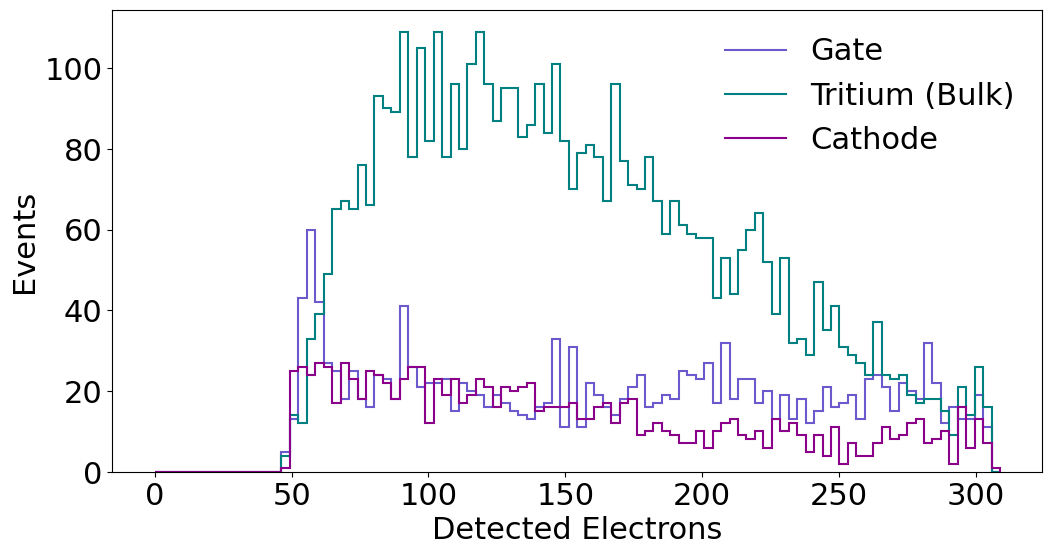

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   4.  14.  12.  33.  39.  49.  65.  67.  65.  76.  66.  93.  90.
  89. 109.  78. 105.  82. 109.  78.  96.  80. 101. 109.  96.  87.  95.
  95.  83.  86.  96.  84. 101.  82.  70.  79.  81.  78.  67.  96.  77.
  71.  70.  78.  67.  59.  67.  61.  59.  58.  58.  43.  53.  44.  55.
  60.  64.  52.  39.  53.  32.  33.  29.  47.  35.  41.  31.  29.  27.
  24.  37.  24.  23.  24.  19.  17.  18.  18.  15.   9.  21.  14.  26.
  16.   0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5. 13. 43.
 60. 42. 27. 25. 18. 25. 18. 16. 24. 23. 18. 41. 26. 21. 22. 22. 23. 15.
 22. 20. 19. 16. 19. 17. 15. 14. 13. 16. 17. 33. 11. 31. 11. 22. 19. 16.
 14. 18. 21. 24. 16. 17. 19. 18. 25. 24. 23. 27. 17. 32. 18. 23. 23. 17.
 20. 13. 19. 13. 18. 12. 15. 21. 16. 17. 19. 13. 23. 24. 21. 15. 22. 20.
 18. 32. 22. 12. 16. 13. 13. 19. 11.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 25. 26.
 24. 27. 26

In [91]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

print(max(cathode_events), max(tritium_events), max(gate_events))

print(f' Total Number of Training Examples {len(arr["label"])}')
a = len(gate_events)
b = len(cathode_events)
c = len(tritium_events)

print(a)
print(b)
print(c)
print(a+b+c)


gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
gate_hist.fill(gate_events)
gate_hist.plot(color='slateblue',density=False,yerr=False,label='Gate')

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
tritium_hist.fill(tritium_events)
tritium_hist.plot(color='teal',density=False,yerr=False,label='Tritium (Bulk)')

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
cathode_hist.fill(cathode_events)
cathode_hist.plot(color='darkmagenta',density=False,yerr=False,label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('Figures/Pulse_Spectrum.png', dpi=1800)
plt.show()

print(tritium_hist.view())
print(gate_hist.view())
print(cathode_hist.view())

305.7223627403846
1189.0
0.0
0.0
0.0032545047259652992


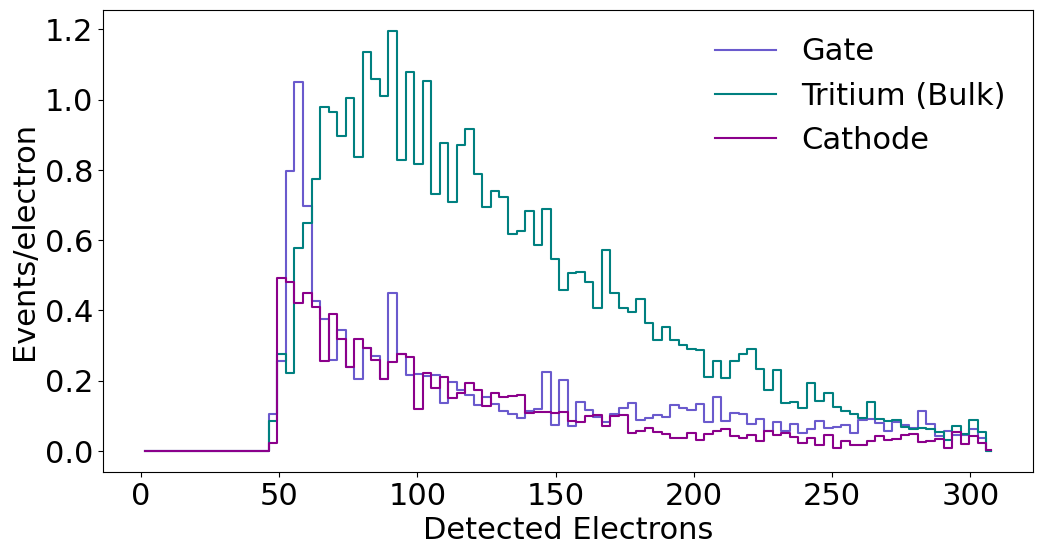

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0)

bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
print(bin_edges[-2])

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers


print(cathode_hist.view().sum())
print(tritium_counts[-1])
print(gate_counts[-1])
print(cathode_counts[-1])


ax.step(bin_centers, gate_counts, where='mid', color='slateblue', label='Gate')
ax.step(bin_centers, tritium_counts, where='mid', color='teal', label='Tritium (Bulk)')
ax.step(bin_centers, cathode_counts, where='mid', color='darkmagenta', label='Cathode')

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1,1),loc='upper right',frameon=False,fontsize=22) 
plt.savefig('Figures/eventsperelectron.png', dpi=1800)
plt.show()

# Weighting the S2 Area Spectrum

MAXareas: tritum,gate, cathode, overall dataset (np.float64(17881.375), np.float64(17847.5546875), np.float64(17886.546875), np.float64(17886.546875))
0.0
0.0
0.0032545047259652992
13.411785247523326
37.54691093085141
10.274164346048565
0
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.4117852

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_4531/746911539.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_4531/746911539.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_4531/746911539.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_4531/746911539.py:75: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_4531/7

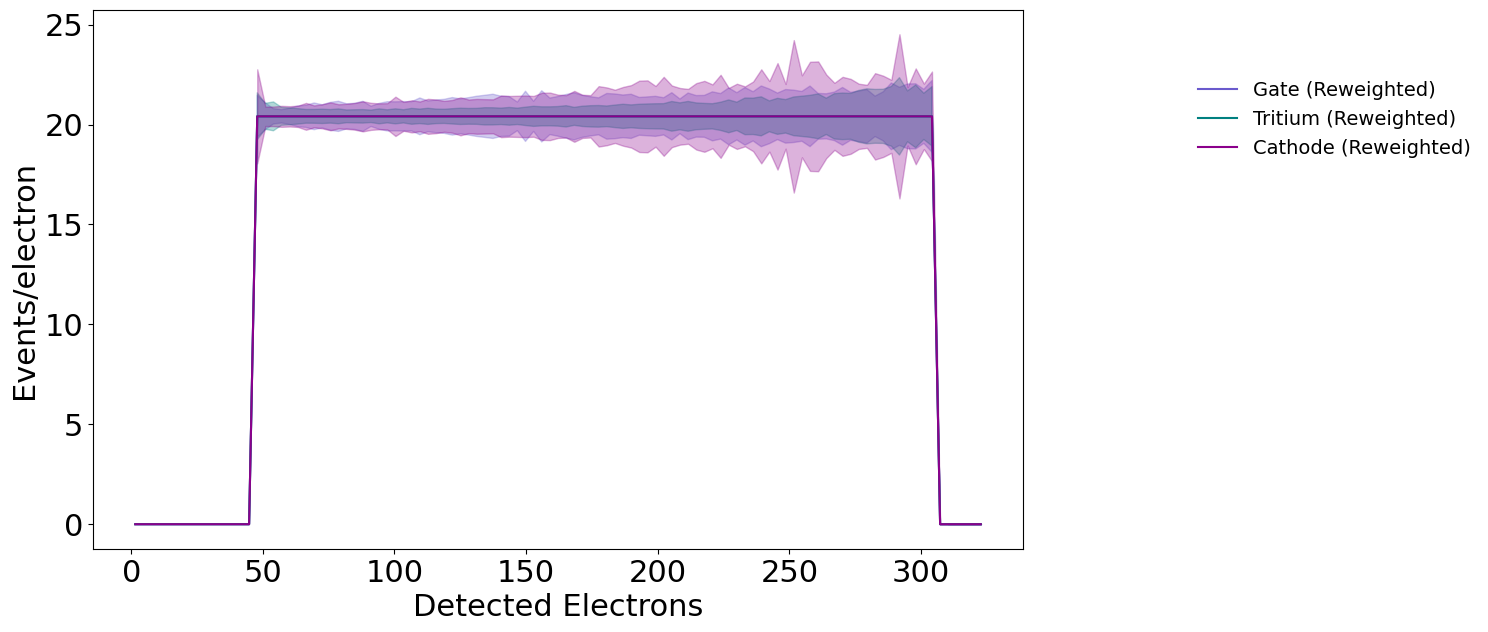

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

### CODE TO DELETE: HERE FOR TESTING PURPOSES ONLY ###

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAXareas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

gate_counts = gate_hist.view() / bin_centers #this is the y - axis data converted to events/electron
print(gate_counts[-1])
print(tritium_counts[-1])
print(cathode_counts[-1])

### 

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 


print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()])

#for datapoint in range(0, len(gate_data)):
    #print(gate_data[datapoint])

#gate_reweighted = np.array([
    #gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0
    #for datapoint in range(len(gate_counts))
#])

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))


tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] > cathode_counts[-1] else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

print(cathode_weights[-1])
    

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

print(gate_reweighted)

# print(gate_reweighted)
# print(tritium_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /60 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /60 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/60 # * (average_counts / cathode_counts.sum())

# Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Plot reweighted data with translucent error bands
# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='slateblue', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='slateblue', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='teal', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='teal', alpha=0.3
)

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='darkmagenta', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='darkmagenta', alpha=0.3
)

#ax.step(bin_centers, gate_reweighted * (average_counts/ gate_counts.sum()), where='mid', color='slateblue', label='Gate (Reweighted)')
#ax.step(bin_centers, tritium_reweighted * (average_counts/ tritium_counts.sum()), where='mid', color='teal', label='Tritium (Bulk, Reweighted)')
#ax.step(bin_centers, cathode_reweighted * (average_counts/ cathode_counts.sum()), where='mid', color='darkmagenta', label='Cathode (Reweighted)')


ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.5,0.9),loc='upper right',frameon=False,fontsize=14) 
plt.savefig('Figures/weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [94]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights)

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)


#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')


#print(gate_data)
#print(gate_weights)

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))


#arr['weight'] = all_weights #the final line to add all weights for each subdataset (gate, cathode and tritium) to main awkward data frame. then can feed into CNN easy.


these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [95]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Optional Code: Normalising the Weights Array

In [96]:
total_weight = ak.sum(arr['weights'])

# Normalize the weights by dividing each element by the total weight
normalized_weights = arr['weights'] / total_weight

# If you want to save the normalized weights back to the array. In Awkward, this is done by duplicating the original array and adding a new column.
arr = ak.with_field(arr, normalized_weights, 'weights_normalized')

print(arr['weights_normalized'])

[0.000543, 2.31e-05, 0.000142, 0.000142, ..., 0.000788, 0.000788, 0.000788]


# Convolutional Neural Network

In [97]:
seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=28, kernel_size=3, activation='relu', input_shape=(3656, 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
convoNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 28 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2,2) specifies a pooling window which means the layer will take the max value from every 2*2 region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons
#10 layer is our 10 neuron layer that provides a class (digit 0-1)

/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
convoNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [99]:
weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalized'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalized_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']
# Assuming you already have 'X_combined' and 'labels' prepared
# Split the data (include 'area' normalization within the split for alignment)


# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test = train_test_split(
    X_combined, labels, normalized_area, weights_np, test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test) # //
print("Shape of y_train:", y_train.shape)

from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.01,      # Minimum change in loss to qualify as an improvement
    patience=3,          # Stop training after 3 epochs of no significant improvement
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restore the weights from the best epoch
)

# Ensure your data is properly prepared
convoNN.fit(
    X_train,
    y_train,
    sample_weight=weights_train,
    validation_split=0.2,  # Use a fraction of the training data for validation
    epochs=10,             # Maximum number of epochs
    batch_size=32,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)

7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 3656)
Shape of y_train: (5836,)
Epoch 1/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7984 - loss: 59.4312 - val_accuracy: 0.8682 - val_loss: 39.5698
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8519 - loss: 44.0020 - val_accuracy: 0.8707 - val_loss: 37.9911
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8612 - loss: 39.6821 - val_accuracy: 0.8741 - val_loss: 36.9689
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8752 - loss: 35.0658 - val_accuracy: 0.8613 - val_loss: 39.2339
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8826 - loss: 32.0077 - val_accuracy: 0.8707 - val_loss: 37.9726
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.8903 - loss: 28.2555 - val_accuracy: 0.8707 - val_loss: 38.3706
Epoch 6: early stopping
Restoring model we

In [100]:
X_test_reshaped = X_test.reshape(-1, 3656, 1)
print(X_test_reshaped.shape)
convoNN.evaluate(X_test_reshaped, y_test)

(1946, 3656, 1)
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8475 - loss: 0.3525


[0.3189951181411743, 0.8612538576126099]

# Visualising the Model Classification Effectiveness: The Probability Distribution

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


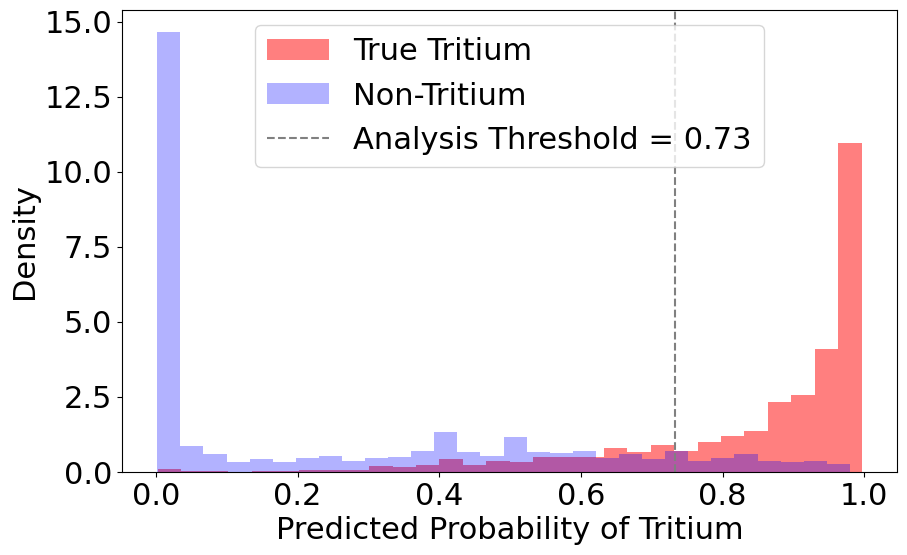

In [101]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Step 1: Get predicted probabilities for each class
y_pred_proba = convoNN.predict(X_test)

predicted_classes = np.argmax(y_pred_proba, axis=1) # axis = 1 signifies that argmax should parse through the columns of each row and find the max. value
# for i in range(30):
    # print(f"True label: {y_test[i]}, Predicted class: {predicted_classes[i]}")  # Initial checking to see how well the model predicts the classes for first 30 training examples 

# Step 2: Calculate background and bulk probabilities
background_proba = y_pred_proba[:, 0] + y_pred_proba[:, 1]  # Sum of Gate and Cathode probabilities
bulk_proba = y_pred_proba[:, 2]  # Tritium probabilities. All the training examples in the training dataset that the model has predicted to be tritium.

# Separate true Tritium events from non-Tritium events in y_test
true_tritium_mask = (y_test == 2) # actual tritium events
non_tritium_mask = (y_test != 2) # non-tritium(background) events

threshold = np.percentile(bulk_proba[true_tritium_mask], 20)

# Step 3: Plot histograms for both groups
plt.figure(figsize=(10, 6))

# Histogram for actual Bulk (Tritium) events
plt.hist(bulk_proba[true_tritium_mask], bins=30, alpha=0.5, color='red', label='True Tritium', density=True)

# Histogram for non-Bulk (Tritium) events
plt.hist(bulk_proba[non_tritium_mask], bins=30, alpha=0.3, color='blue', label='Non-Tritium', density=True)

# Add titles and labels
# plt.title('Predicted Probability Histogram for Tritium Classification')
plt.axvline(x=threshold, color='gray', linestyle='--', label=f'Analysis Threshold = {threshold:.2f}')
plt.xlabel('Predicted Probability of Tritium')
plt.ylabel('Density')
plt.legend(loc='upper center')

plt.show()


# Creating the ROC Curves

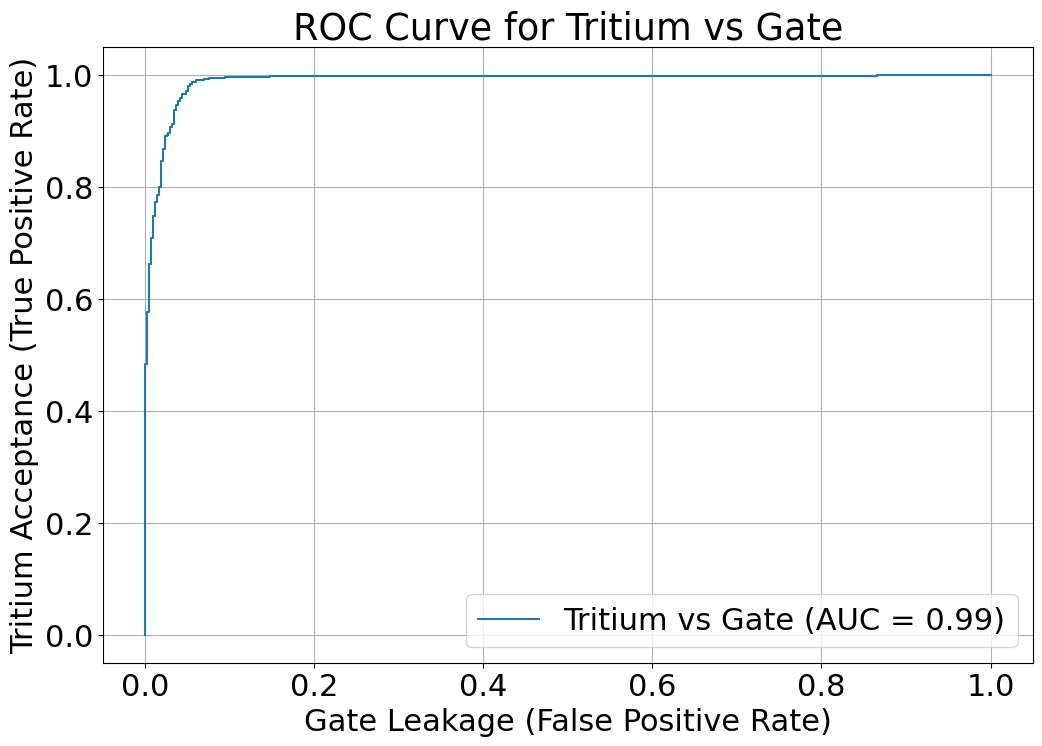

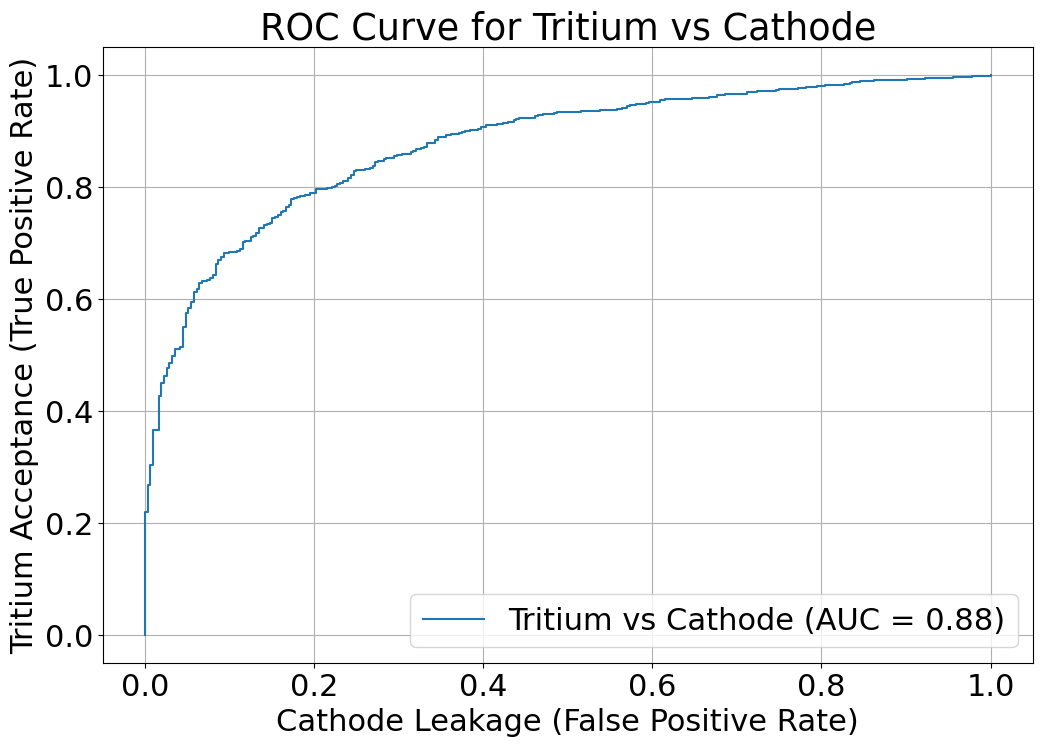

In [102]:
# Tritium vs Gate (Binary labels: Tritium as 1, Gate as 0; ignore Cathode instances)
mask_tritium_gate = (y_test == 2) | (y_test == 1)  # Only consider tritium and gate instances
y_test_tritium_gate = np.where(y_test[mask_tritium_gate] == 2, 1, 0)  # Tritium = 1, Gate = 0
fpr_gate, tpr_gate, _ = roc_curve(y_test_tritium_gate, y_pred_proba[mask_tritium_gate, 2])
roc_auc_gate = auc(fpr_gate, tpr_gate)

# Tritium vs Cathode (Binary labels: Tritium as 1, Cathode as 0; ignore Gate instances)
mask_tritium_cathode = (y_test == 2) | (y_test == 0)  # Only consider tritium and cathode instances
y_test_tritium_cathode = np.where(y_test[mask_tritium_cathode] == 2, 1, 0)  # Tritium = 1, Cathode = 0
fpr_cathode, tpr_cathode, _ = roc_curve(y_test_tritium_cathode, y_pred_proba[mask_tritium_cathode, 2])
# print(_) these are the array of thresholds used by the roc algorithm
roc_auc_cathode = auc(fpr_cathode, tpr_cathode)

# Step 3: Plot ROC curves with verification of each set
plt.figure(figsize=(12, 8))

# Plot for Tritium vs Gate
plt.plot(fpr_gate, tpr_gate, label=f'Tritium vs Gate (AUC = {roc_auc_gate:.2f})')
plt.xlabel('Gate Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Gate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot for Tritium vs Cathode
plt.figure(figsize=(12, 8))
plt.plot(fpr_cathode, tpr_cathode, label=f'Tritium vs Cathode (AUC = {roc_auc_cathode:.2f})')
plt.xlabel('Cathode Leakage (False Positive Rate)')
plt.ylabel('Tritium Acceptance (True Positive Rate)')
plt.title('ROC Curve for Tritium vs Cathode')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


[ 48.75882245 100.02433894 151.28985544 202.55537193 253.82088842
 305.08640491]
y_test_np shape: (1946,)
area_test_np shape: (1946,)


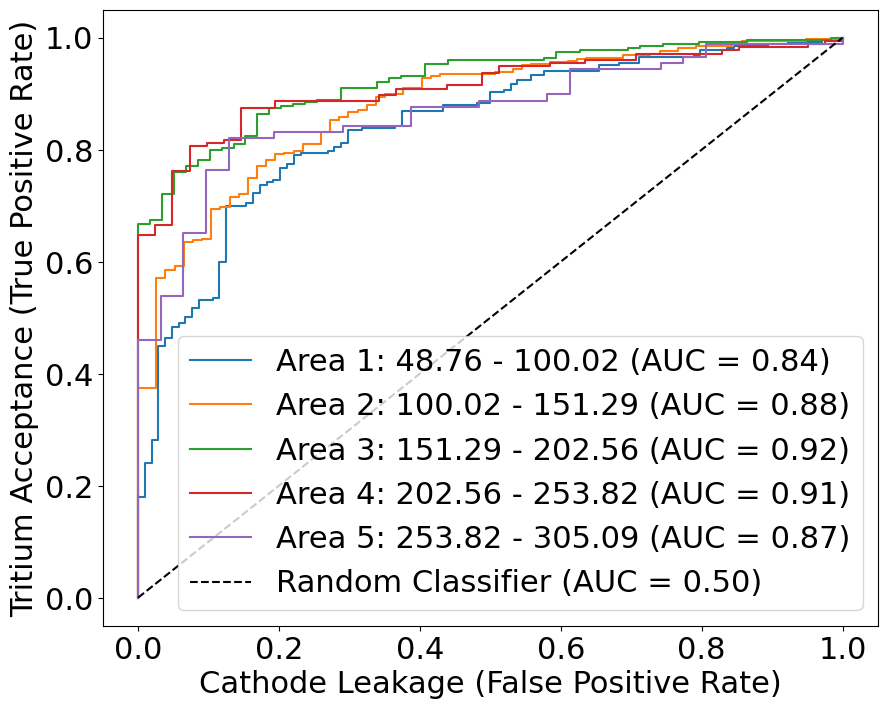

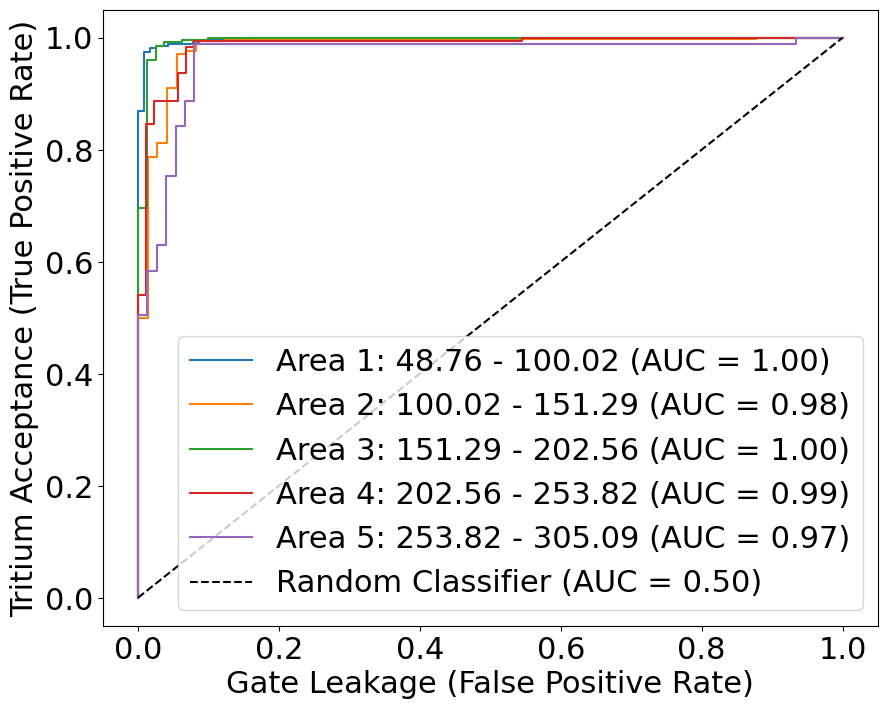

In [103]:
# Define function to split data into 5 regions based on normalized area for the test set
def get_area_intervals(normalized_area, num_intervals=5):
    min_area = np.min(normalized_area)
    max_area = np.max(normalized_area)
    intervals = np.linspace(min_area, max_area, num_intervals + 1)
    return intervals

# Calculate intervals for splitting area into 5 regions
area_intervals = get_area_intervals(area_test)
print(area_intervals)

# Convert y_test and area_test to NumPy arrays for easier indexing
y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

# Check conversion
print("y_test_np shape:", y_test_np.shape)
print("area_test_np shape:", area_test_np.shape)

def plot_roc_for_intervals(event_type, y_test, y_pred_proba, label, area_intervals):
    plt.figure(figsize=(10, 8))
    for i in range(len(area_intervals) - 1):
        # Define range for the current interval
        lower, upper = area_intervals[i], area_intervals[i + 1]
        
        # Mask to select data within the current area range and specific event type
        mask = (area_test_np >= lower) & (area_test_np < upper) & ((y_test_np == event_type) | (y_test_np == 2))
        # print(f' this is {y_test_np[mask]}')
        
        # Check if mask correctly applies to y_test
        if np.any(mask):  # Ensure mask is not empty. np.any() returns a boolean value iff any element within 'mask' is true
            y_test_interval = np.where(y_test_np[mask] == 2, 1, 0)  # Tritium = 1, event_type = 0
            
            # Compute ROC for this interval
            fpr, tpr, _ = roc_curve(y_test_interval, y_pred_proba[mask, 2])
            roc_auc = auc(fpr, tpr)
            
            # Plot the ROC curve for this interval
            plt.plot(fpr, tpr, label=f'Area {i+1}: {lower:.2f} - {upper:.2f} (AUC = {roc_auc:.2f})')
    
    # Plot the random classifier line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
    
    # Add labels and title
    plt.xlabel(f'{label} Leakage (False Positive Rate)')
    plt.ylabel('Tritium Acceptance (True Positive Rate)')
    # plt.title(f'ROC Curves for Tritium vs {label} across Area Regions')
    plt.legend(loc='lower right')
    plt.show()

# Step 4: Plot ROC curves for Tritium vs Cathode
plot_roc_for_intervals(event_type=0, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Cathode', area_intervals=area_intervals)

# Step 5: Plot ROC curves for Tritium vs Gate
plot_roc_for_intervals(event_type=1, y_test=y_test_np, y_pred_proba=y_pred_proba, label='Gate', area_intervals=area_intervals)


## Figure 7 (LUX-LOWMASS) Production

The probability threshold corresponding to 80% of the tritium data lying after that line is 0.732


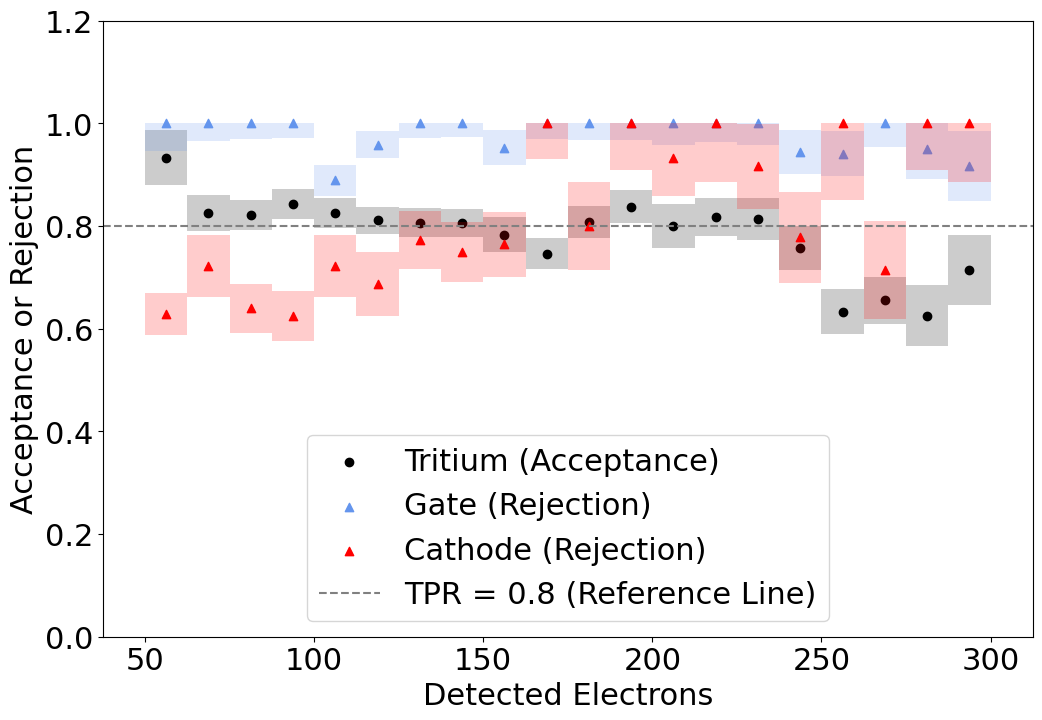

In [104]:
# Increase the number of bins for more points in the scatter plot
num_bins = 20 # Adjust this number to make the bins smaller and create more points

print(f"The probability threshold corresponding to 80% of the tritium data lying after that line is {threshold:.3f}")

bin_edges = np.linspace(50, 300, num_bins + 1)  # Uniform bins between 50 and 300

# Placeholder for storing acceptance values
# Placeholder for storing acceptance and rejection values
tritium_acceptance = []
gate_rejection = []
cathode_rejection = []
tritium_error = []
gate_error = []
cathode_error = []

# Function to calculate bin widths
def calculate_bin_widths(bin_edges):
    return bin_edges[1] - bin_edges[0]

# Loop through each bin
for i in range(len(bin_edges) - 1):
    # Define bin range
    lower, upper = bin_edges[i], bin_edges[i + 1]
    bin_center = (lower + upper) / 2
    bin_width = calculate_bin_widths(bin_edges)  # Dynamic bin width

    # Filter data points within the current bin
    mask = (area_test_np >= lower) & (area_test_np < upper)
    
    if np.any(mask):  # Skip bins with no data points
        # Extract data points for Tritium, Gate, and Cathode
        tritium_mask = mask & (y_test_np == 2)
        gate_mask = mask & (y_test_np == 1)
        cathode_mask = mask & (y_test_np == 0)

        # Calculate acceptance for Tritium
        tritium_proba = y_pred_proba[tritium_mask, 2]
        if len(tritium_proba) > 0:  # Ensure there are Tritium samples
           # dynamic_threshold = np.percentile(tritium_proba, 20)  # 20th percentile threshold for this bin
            accepted_tritium = np.sum(tritium_proba >= threshold)  # Count Tritium points above threshold
            total_tritium = len(tritium_proba)
            tritium_acceptance.append((bin_center, accepted_tritium / total_tritium))  # Normalize by true Tritium count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            tritium_error.append(min(error,1))
        else:
            tritium_acceptance.append((bin_center, 0))  # No Tritium events in this bin

        # Calculate rejection rates for Gate and Cathode
        gate_proba = y_pred_proba[gate_mask, 2]
        if len(gate_proba) > 0:
            rejected_gate = np.sum(gate_proba <= threshold)  # true negatives (in terms of actual signal events) for Gate
            total_gate = len(gate_proba)
            gate_rejection.append((bin_center, (rejected_gate / total_gate)))  # Normalise by true Gate count
            error = (np.sqrt(accepted_tritium) / total_tritium) * 0.3
            gate_error.append(min(error,1))
        else:
            gate_rejection.append((bin_center, 0))

        cathode_proba = y_pred_proba[cathode_mask, 2]
        if len(cathode_proba) > 0:
            rejected_cathode = np.sum(cathode_proba <= threshold)  # true negatives (in terms of actual signal events) for Cathode
            total_cathode = len(cathode_proba)
            cathode_rejection.append((bin_center, (rejected_cathode) / total_cathode))  # Normalise by true Cathode count
            error = (np.sqrt(rejected_cathode) / total_cathode) * 0.3
            cathode_error.append(min(error,1))
        else:
            cathode_rejection.append((bin_center, 0))

# Convert collected points into arrays for plotting
tritium_x, tritium_y = zip(*tritium_acceptance)
gate_x, gate_y = zip(*gate_rejection)
cathode_x, cathode_y = zip(*cathode_rejection)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot Tritium acceptance points with error bars
for x, y, error in zip(tritium_x, tritium_y, tritium_error):
    plt.scatter(x, y, color='black', label='Tritium (Acceptance)' if x == tritium_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='black', alpha=0.2, linewidth=0)

# Plot Gate rejection points with error bars
for x, y, error in zip(gate_x, gate_y, gate_error):
    plt.scatter(x, y, color='cornflowerblue', marker='^', label='Gate (Rejection)' if x == gate_x[0] else "")
    plt.fill_betweenx([y - error, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='cornflowerblue', alpha=0.2, linewidth=0)

# Plot Cathode rejection points with error bars
for x, y, error in zip(cathode_x, cathode_y, cathode_error):
    plt.scatter(x, y, color='red', marker='^', label='Cathode (Rejection)' if x == cathode_x[0] else "")
    plt.fill_betweenx([y - error,1, min(y + error, 1)], x - bin_width / 2, x + bin_width / 2, color='red', alpha=0.2, linewidth=0)


plt.axhline(y=0.8, color='gray', linestyle='--', label='TPR = 0.8 (Reference Line)')
plt.ylim(0, 1.2)

plt.xlabel("Detected Electrons")
plt.ylabel("Acceptance or Rejection")
plt.legend(loc='lower center')
plt.show()




In [105]:
print("X_train shape:", X_train.shape)

# Define the padding length
padding_length = 500  # 5 ms worth of samples at 10 ns per sample

# Add zero-padding on each side of the data (only along the time dimension for 2D data)
X_train_padded = np.pad(X_train, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X_test_padded = np.pad(X_test, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)

X_train shape: (5836, 3656)


## [Technique 1] Random Search Optimisation

Testing: LR=0.01, Batch Size=16, Stride=2, Filters=32


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8171
Testing: LR=0.0001, Batch Size=64, Stride=5, Filters=16
Restoring model weights from the end of the best epoch: 5.
Test Accuracy: 0.8628
Testing: LR=0.001, Batch Size=64, Stride=10, Filters=16
Restoring model weights from the end of the best epoch: 5.
Test Accuracy: 0.8880
Testing: LR=0.05, Batch Size=16, Stride=5, Filters=64
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.6172
Testing: LR=0.001, Batch Size=64, Stride=5, Filters=64
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8520
Testing: LR=0.01, Batch Size=16, Stride=1, Filters=128
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8140
Testing: LR=0.01, Batch Size=64, Stride=3, Filters=16
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test 

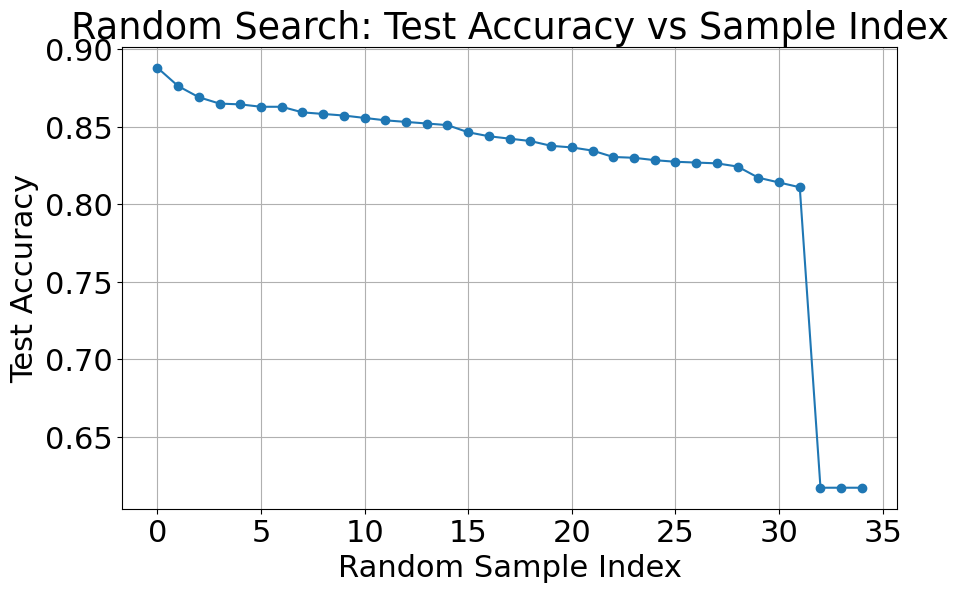

In [106]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define ranges for hyperparameters
learning_rate_range = [1e-4, 1e-3, 1e-2, 5e-2]
batch_size_range = [16, 32, 64]
stride_range = [1, 2, 3, 5, 10, 20, 50]
num_filters_range = [16, 32, 64, 128]

# Number of random samples to try
num_samples = 35

# Store results
results = []

for _ in range(num_samples):
    # Randomly sample hyperparameters
    lr = random.choice(learning_rate_range)
    batch_size = random.choice(batch_size_range)
    stride = random.choice(stride_range)
    filters = random.choice(num_filters_range)
    
    print(f"Testing: LR={lr}, Batch Size={batch_size}, Stride={stride}, Filters={filters}")
    
    # Define the model
    model = Sequential([
        Conv1D(filters=filters, kernel_size=200, strides=stride, activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_padded, y_train, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    
    # Append results
    results.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'stride': stride,
        'filters': filters,
        'accuracy': test_accuracy
    })
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Sort results by accuracy
results = sorted(results, key=lambda x: x['accuracy'], reverse=True) # sorted(): A Python built-in function that returns a new sorted list from the original list. 
# It doesn’t modify the original list but creates a new sorted version. Sorted in descending order

# Display top-performing hyperparameter combinations
print("\nTop 5 hyperparameter combinations:")
for i, result in enumerate(results[:5]):
    print(f"{i+1}. LR={result['learning_rate']}, Batch Size={result['batch_size']}, "
          f"Stride={result['stride']}, Filters={result['filters']}, Accuracy={result['accuracy']:.4f}")

# Visualize the accuracy of random samples
accuracies = [res['accuracy'] for res in results]
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o')
plt.xlabel("Random Sample Index")
plt.ylabel("Test Accuracy")
plt.title("Random Search: Test Accuracy vs Sample Index")
plt.grid(True)
plt.show()


## [Technique 2] Bayesian Optimisation

Testing: LR=0.024526126311336792, Batch Size=107, Stride=3, Filters=83


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8279
Testing: LR=0.002175195311877766, Batch Size=66, Stride=2, Filters=53
Test Accuracy: 0.8839
Testing: LR=0.0002682875093825439, Batch Size=339, Stride=1, Filters=97
Test Accuracy: 0.8885
Testing: LR=0.06541210527692738, Batch Size=16, Stride=3, Filters=85
Test Accuracy: 0.8258
Testing: LR=0.0068384784309640494, Batch Size=20, Stride=1, Filters=75
Test Accuracy: 0.8320
Testing: LR=0.0015833718339012064, Batch Size=39, Stride=3, Filters=42
Test Accuracy: 0.8911
Testing: LR=0.00018699039697141505, Batch Size=323, Stride=2, Filters=126
Test Accuracy: 0.8751
Testing: LR=0.0025135566617708297, Batch Size=443, Stride=2, Filters=66
Test Accuracy: 0.8813
Testing: LR=0.00010959604536925845, Batch Size=483, Stride=2, Filters=59
Test Accuracy: 0.8392
Testing: LR=0.00011166029133981341, Batch Size=131, Stride=1, Filters=93
Test Accuracy: 0.8864
Testing: LR=0.0005476025478734449, Batch Size=218, Stride=1, Filters=59


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8977
Testing: LR=0.0002883030566261754, Batch Size=16, Stride=1, Filters=34


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8869
Testing: LR=0.000744183022099683, Batch Size=405, Stride=1, Filters=112


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8875
Testing: LR=0.0010831129450630437, Batch Size=216, Stride=3, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8890
Testing: LR=0.1, Batch Size=512, Stride=1, Filters=21


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.6172
Testing: LR=0.0001, Batch Size=16, Stride=3, Filters=16


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8762
Testing: LR=0.0015165252661479857, Batch Size=512, Stride=3, Filters=16


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8654
Testing: LR=0.00047095320695250947, Batch Size=16, Stride=3, Filters=96


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8859
Testing: LR=0.0030903956655260584, Batch Size=217, Stride=3, Filters=28


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8854
Testing: LR=0.001697000112686655, Batch Size=280, Stride=1, Filters=20


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8854
Testing: LR=0.0007575125096611489, Batch Size=242, Stride=2, Filters=16


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8890
Testing: LR=0.000748965577963421, Batch Size=52, Stride=1, Filters=103


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8844
Testing: LR=0.0047709892682340094, Batch Size=19, Stride=3, Filters=114


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8859
Testing: LR=0.0003051911047833583, Batch Size=164, Stride=1, Filters=105


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8941
Testing: LR=0.00010425820706596132, Batch Size=16, Stride=1, Filters=66


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8900
Testing: LR=0.0005212287192013393, Batch Size=241, Stride=1, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8869
Testing: LR=0.0018053568569644587, Batch Size=16, Stride=3, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8921
Testing: LR=0.0013287010189764815, Batch Size=512, Stride=1, Filters=16


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8695
Testing: LR=0.0012501444142885827, Batch Size=272, Stride=2, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8926
Testing: LR=0.0030485744292678453, Batch Size=269, Stride=3, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8972
Testing: LR=0.0019422958748343015, Batch Size=221, Stride=3, Filters=84


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8859
Testing: LR=0.00010101048979654348, Batch Size=259, Stride=1, Filters=19


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8592
Testing: LR=0.0001840695681038039, Batch Size=16, Stride=1, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8854
Testing: LR=0.1, Batch Size=16, Stride=3, Filters=128


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.6172
Testing: LR=0.00045350604700567404, Batch Size=445, Stride=1, Filters=16


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test Accuracy: 0.8659

Best Hyperparameters:
Learning Rate: 0.00055
Batch Size: 218
Stride: 1
Number of Filters: 59
Best Test Accuracy: 0.8977


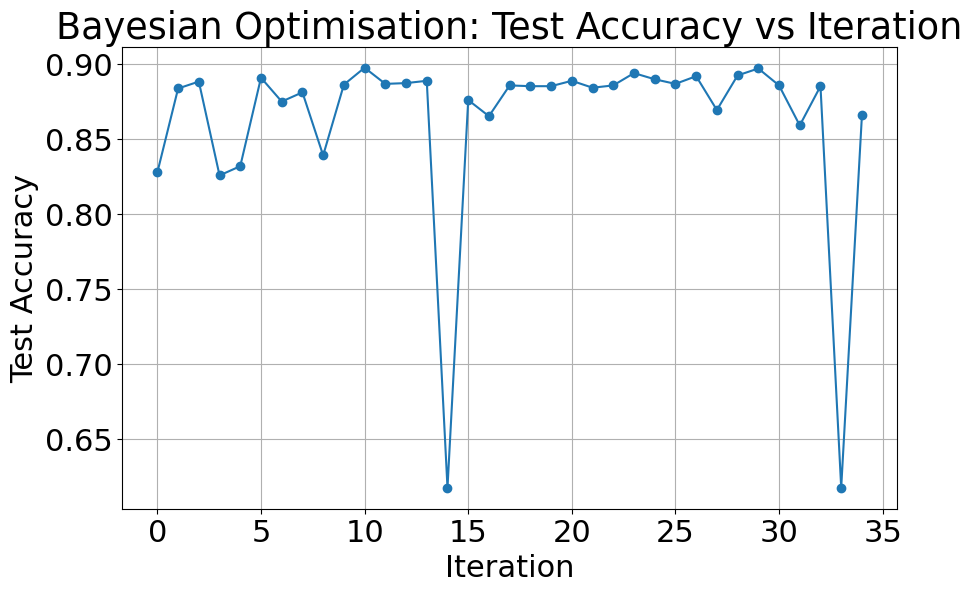

In [107]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Define hyperparameter space
space = [
    Real(1e-4, 1e-1, name='learning_rate', prior='log-uniform'),  # Learning rate (log scale)
    Integer(16, 512, name='batch_size'),                         # Batch size
    Integer(1, 3, name='stride'),                               # Stride
    Integer(16, 128, name='num_filters')                        # Number of filters
]

# Function to evaluate model performance with given hyperparameters 
@use_named_args(space) # Decorator function converts a list of arguments (provided as positional arguments by gp_minimize) 
# into named arguments so that the objective function can accept and work with them directly.
def objective(learning_rate, batch_size, stride, num_filters):
    print(f"Testing: LR={learning_rate}, Batch Size={batch_size}, Stride={stride}, Filters={num_filters}")
    
    # Define the model
    model = Sequential([
        Conv1D(filters=num_filters, kernel_size=200, strides=(stride,), activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_padded, y_train, epochs=5, batch_size=batch_size, validation_split=0.2, verbose=0)
    
    # Evaluate the model
    _, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Minimise negative accuracy (maximise accuracy)
    return -test_accuracy

# Run Bayesian optimisation
results = gp_minimize(objective, space, n_calls=35, random_state=42)

# Extract the best result
best_hyperparams = results.x # This provides the best combination of hyperparameters found during the optimisation. It is a list of values corresponding to the hyperparameters defined in the search space.
best_score = -results.fun # This provides the minimum value of the objective function (loss) achieved during the optimisation process.

print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_hyperparams[0]:.5f}")
print(f"Batch Size: {best_hyperparams[1]}")
print(f"Stride: {best_hyperparams[2]}")
print(f"Number of Filters: {best_hyperparams[3]}")
print(f"Best Test Accuracy: {best_score:.4f}")

# Visualize the convergence of Bayesian optimisation
plt.figure(figsize=(10, 6))
plt.plot(-np.array(results.func_vals), marker='o')
plt.xlabel("Iteration")
plt.ylabel("Test Accuracy")
plt.title("Bayesian Optimisation: Test Accuracy vs Iteration")
plt.grid(True)
plt.show()


## Exclusive Learning Rate Optimisation (using Bayesian Optimal Parameters for All Other Hyperparams)

Testing learning rate: 1.21413e-02


/Users/laith_mohajer/Documents/GitHub/MSCIProject/myenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8124
Testing learning rate: 3.43817e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8345
Testing learning rate: 1.03491e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8253
Testing learning rate: 1.58820e-02
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8165
Testing learning rate: 8.08699e-03
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8263
Testing learning rate: 9.28044e-03
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.8088
Testing learning rate: 1.20680e-02
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Test Accuracy: 0.6172
Testing learning rate: 1.58433e-04
Epoch 3: early stopp

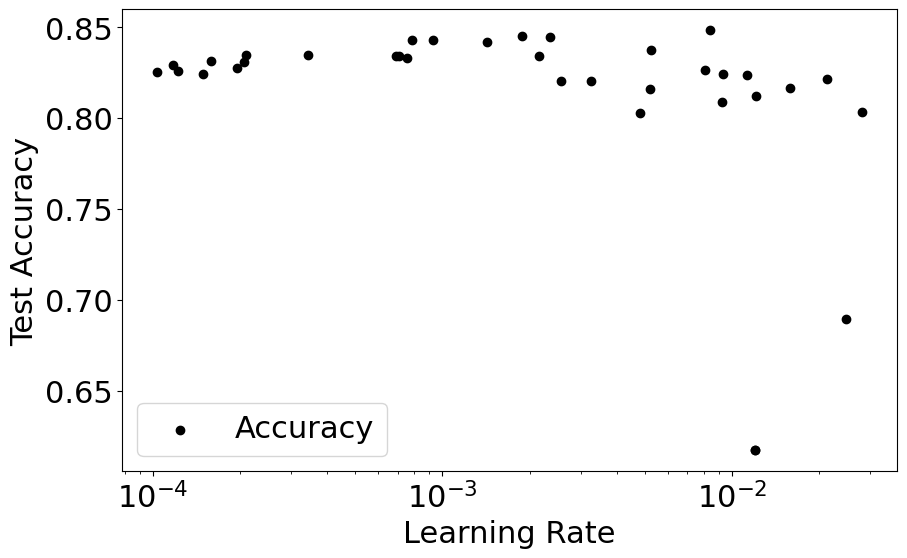

In [110]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the range for learning rates
min_lr = 1e-4
max_lr = 5e-2

# Generate random learning rates in a log-uniform distribution
num_trials = 35  # Number of random learning rates to test
random_learning_rates = np.random.uniform(np.log10(min_lr), np.log10(max_lr), num_trials) # Ensures an equal probability of an lr being chosen throughout the specified range
random_learning_rates = 10 ** random_learning_rates  # Convert back to linear scale

# Placeholder for storing results
learning_rate_accuracies = []

# Loop through each random learning rate
for lr in random_learning_rates:
    print(f"Testing learning rate: {lr:.5e}")
    
    # Define the model
    model = Sequential([
        Conv1D(filters=best_hyperparams[3], kernel_size=200, strides=(best_hyperparams[2],), activation='relu', input_shape=(X_train_padded.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    
    # Compile the model with the current learning rate
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train_padded, y_train, epochs=5, batch_size=best_hyperparams[1], validation_split=0.2, verbose=0, callbacks = [early_stopping])
    
    # Evaluate on the test set
    _, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0) # loss variable is ignored using python conventional ignore variable '_'
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Save the accuracy for this learning rate
    learning_rate_accuracies.append((lr, test_accuracy))

# Sort the results by accuracy
learning_rate_accuracies = sorted(learning_rate_accuracies, key=lambda x: x[1], reverse=True)

# Print the best learning rate
best_lr, best_accuracy = learning_rate_accuracies[0]
print(f"\nBest Learning Rate: {best_lr:.5e}, Best Test Accuracy: {best_accuracy:.4f}")

# Plot learning rate vs. accuracy
plt.figure(figsize=(10, 6))
lrs, accuracies = zip(*learning_rate_accuracies) # '*' operator unpacks the list into seperate arguements and 'zip' transforms each argument into two iterable variables. 
plt.scatter(lrs, accuracies, marker='o', color = 'black',label="Accuracy")
plt.xscale('log')  # Use xscale instead of semilogx for scatter plots
# plt.semilogx(lrs, accuracies, marker='o', color='black', label="Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Test Accuracy")
# plt.title("Learning Rate Optimisation")
# plt.grid(True)
plt.legend()
plt.savefig('Figures/lroptimisation.png')
plt.show()
